In [1]:
# Import necessary modules first.
import tensorflow as tf
from keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d jangedoo/utkface-new
!unzip -q utkface-new.zip

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 331M/331M [00:09<00:00, 40.8MB/s]
100% 331M/331M [00:09<00:00, 37.5MB/s]


In [3]:
BASE_DIR = '/content/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  gender_label = int(img_components[1])

  # Append the image_path and gender_label
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
print(f'Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of gender_labels: 23708, Number of image_paths: 23708


In [5]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [6]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['gender'] = image_paths, gender_labels
df.head(5)

,image_path,gender
0,/content/UTKFace/52_0_0_20170109005553829.jpg....,0
1,/content/UTKFace/105_1_0_20170112213001988.jpg...,1
2,/content/UTKFace/19_0_1_20170114025936564.jpg....,0
3,/content/UTKFace/66_1_0_20170110140921650.jpg....,1
4,/content/UTKFace/37_0_1_20170116202035694.jpg....,0


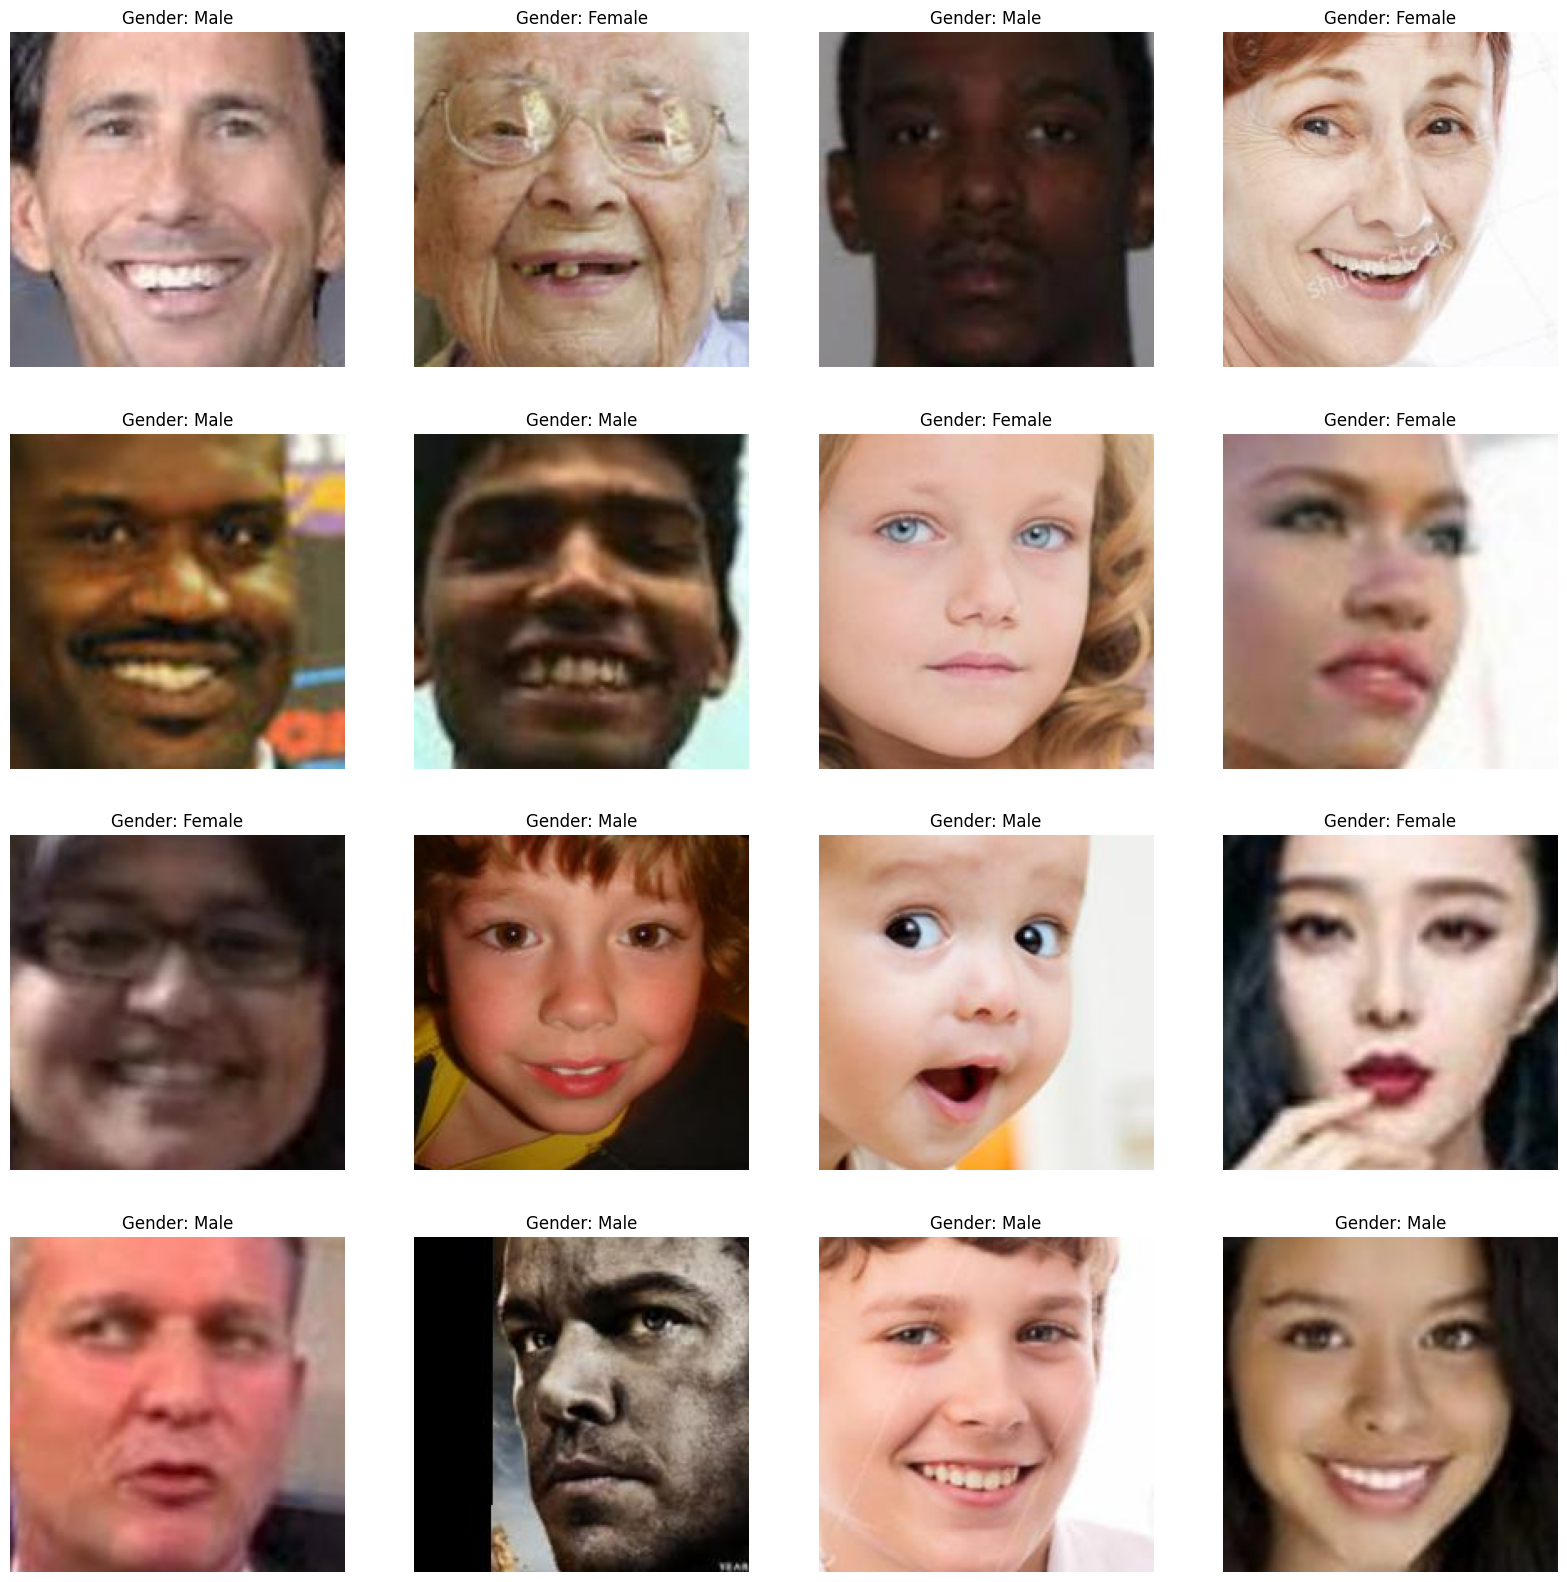

In [9]:
from PIL import Image

plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Gender: {gender_mapping[gender]}')
    plt.imshow(img)

In [29]:
import cv2

# Function to apply preprocessing techniques
def preprocess_image(image):
    # Resize image
    resized_image = cv2.resize(image, (128, 128))

    # Convert to grayscale
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(grayscale_image)

    # Apply sharpening
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened_image = cv2.filter2D(equalized_image, -1, kernel)

    # Normalize pixel values
    normalized_image = sharpened_image / 255.0

    return normalized_image

/content/UTKFace/3_1_0_20170109191231140.jpg.chip.jpg
4245


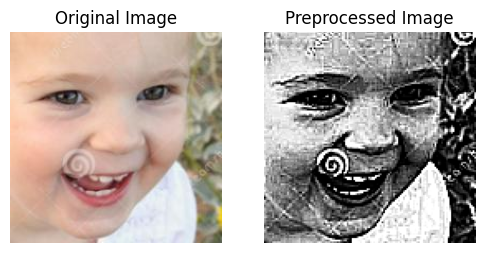

In [87]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Select a random image path
#random_index = np.random.randint(len(df))
random_index = 4245
random_image_path = df['image_path'].iloc[random_index]
print(random_image_path)
print(random_index)

# Load and display the original image
original_img = cv2.imread(random_image_path)

# Preprocess the image
preprocessed_img = preprocess_image(original_img)

# Create a figure with two subplots
plt.figure(figsize=(6, 3))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display preprocessed image
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_img, cmap='gray')
plt.title('Preprocessed Image')
plt.axis('off')

plt.show()

In [37]:
OUTPUT_DIR = '/content/PreprocessedImages'

# Create the output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Iterate through each image in the dataset directory
for image_file in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, image_file)

    # Read image
    image = cv2.imread(image_path)

    # Apply preprocessing
    preprocessed_image = preprocess_image(image)

    # Save preprocessed image to the output directory
    output_path = os.path.join(OUTPUT_DIR, image_file)
    cv2.imwrite(output_path, preprocessed_image)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [38]:
df['preprocessed_image_path'] = df['image_path'].apply(lambda x: os.path.join(OUTPUT_DIR, os.path.basename(x)))

In [39]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [40]:
# Preprocess the entire dataset
#X = extract_image_features(df['image_path'])

# Apply feature extraction on preprocessed images
X_processed = extract_image_features(df['preprocessed_image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [41]:
X_processed.shape
#X = X / 255.0

(23708, 128, 128, 1)

In [42]:
y_gender = np.array(df['gender'])

In [43]:
input_shape = (128, 128, 1)

In [64]:
inputs = Input((input_shape))

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)

# Fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid', name='gender_out')(x)

model = Model(inputs=[inputs], outputs=[x])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets
X_train, X_test, y_gender_train, y_gender_test = train_test_split(X_processed, y_gender, test_size=0.2, random_state=42)

# Training the model
history = model.fit(x=X_train, y=y_gender_train, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
475/475 [==============================] - 4s 8ms/step - loss: 0.1835 - accuracy: 0.9221 - val_loss: 0.4269 - val_accuracy: 0.8636
Epoch 2/20
475/475 [==============================] - 4s 8ms/step - loss: 0.0650 - accuracy: 0.9768 - val_loss: 0.7042 - val_accuracy: 0.8545
Epoch 3/20
475/475 [==============================] - 4s 8ms/step - loss: 0.0309 - accuracy: 0.9895 - val_loss: 0.7986 - val_accuracy: 0.8627
Epoch 4/20
475/475 [==============================] - 4s 8ms/step - loss: 0.0219 - accuracy: 0.9925 - val_loss: 0.9429 - val_accuracy: 0.8518
Epoch 5/20
475/475 [==============================] - 4s 8ms/step - loss: 0.0188 - accuracy: 0.9937 - val_loss: 0.9139 - val_accuracy: 0.8577
Epoch 6/20
475/475 [==============================] - 4s 8ms/step - loss: 0.0140 - accuracy: 0.9951 - val_loss: 1.1596 - val_accuracy: 0.8520
Epoch 7/20
475/475 [==============================] - 4s 8ms/step - loss: 0.0195 - accuracy: 0.9927 - val_loss: 1.1539 - val_accuracy: 0.8577
Epoch 

In [75]:
# Evaluating the model on the testing set
loss, gender_accuracy = model.evaluate(X_test, y_gender_test)

print("Testing Loss:", loss)
print("Gender Accuracy:", gender_accuracy)

149/149 [==============================] - 1s 3ms/step - loss: 1.1689 - accuracy: 0.8574
Testing Loss: 1.1689040660858154
Gender Accuracy: 0.8574441075325012


149/149 [==============================] - 1s 4ms/step
Accuracy: 0.8574441164065795
Confusion Matrix:
[[2136  315]
 [ 361 1930]]
Precision: 0.8596881959910914
Recall: 0.8424268878219118
F1 Score: 0.8509700176366842


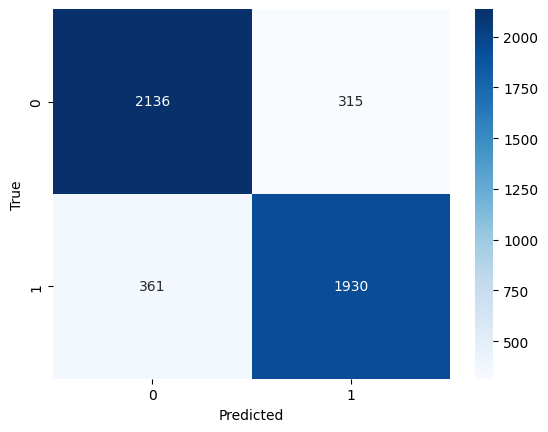

In [76]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_gender_test, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(y_gender_test, y_pred)
print("Confusion Matrix:")
print(cm)

# precision
precision = precision_score(y_gender_test, y_pred)
print("Precision:", precision)

# recall
recall = recall_score(y_gender_test, y_pred)
print("Recall:", recall)

# f1 score
f1 = f1_score(y_gender_test, y_pred)
print("F1 Score:", f1)

# visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

4245
1/1 [==============================] - 0s 21ms/step


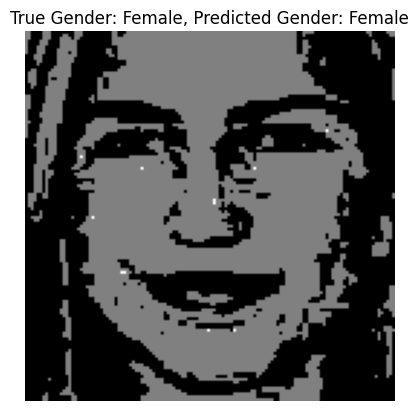

In [86]:
# Select a random index from the testing set
random_index = random.randint(0, len(X_test) - 1)
print(random_index)

# Get the corresponding image and gender from the testing set
test_image = X_test[random_index]
true_gender = y_gender_test[random_index]

# Predict gender for the selected image
predicted_gender = model.predict(np.expand_dims(test_image, axis=0))

# Print the true and predicted gender along with the image
plt.imshow(test_image.reshape(128, 128), cmap='gray')
plt.axis('off')
plt.title(f'True Gender: {gender_mapping[true_gender]}, Predicted Gender: {gender_mapping[int(round(predicted_gender[0][0]))]}')
plt.show()